In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!ls ./gdrive/MyDrive/NLP/

PracticeData  question2question1.pt  question2question.pt  tokenizer.pkl


In [3]:
!wget http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv

--2021-06-23 10:42:21--  http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv
Resolving qim.fs.quoracdn.net (qim.fs.quoracdn.net)... 151.101.1.2, 151.101.65.2, 151.101.129.2, ...
Connecting to qim.fs.quoracdn.net (qim.fs.quoracdn.net)|151.101.1.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58176133 (55M) [text/tab-separated-values]
Saving to: ‘quora_duplicate_questions.tsv’

quora_duplicate_que 100%[===================>]  55.48M   178MB/s    in 0.3s    

2021-06-23 10:42:23 (178 MB/s) - ‘quora_duplicate_questions.tsv’ saved [58176133/58176133]



In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("quora_duplicate_questions.tsv", sep='\t')
print(df.shape)
df

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.data import Field, BucketIterator, Example, Dataset

import spacy
import numpy as np

import random
import math
import time

In [7]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
#!pip install spacy --upgrade

In [8]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [9]:
spacy_en = spacy.load('en_core_web_sm')

In [10]:
SRC = Field(tokenize = tokenize_en,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            include_lengths=True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            include_lengths=True)

In [11]:
fields = [('question1', SRC), ('question2', TRG)]

In [12]:
df.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [13]:
# Taking sample fo dataset
#df1 = df.iloc[:5000,:]
#print(df1.shape)
df = df[df['is_duplicate'] == 1]

In [14]:
print(df.question1.value_counts())
print(df.question1.apply(len) > 1)
print(df.shape[0])

How do I improve my English speaking?                                                         50
How does the ban on 500 and 1000 rupee notes helps to identify black money and corruption?    48
How can changing 500 and 1000 rupee notes end the black money in India?                       47
How do I improve my English language?                                                         47
What should I do to earn money online?                                                        46
                                                                                              ..
How can you be a werewolf in real life?                                                        1
Where can I find an efficient rubbish removal service?                                         1
Why does Israel engage in aparthied?                                                           1
Which is your favourite question and favourite answer on Quora?                                1
What does 'dragon blood' do in

In [15]:
df.reset_index(inplace=True, drop=True)

In [16]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
1,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
2,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
3,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
4,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149263 entries, 0 to 149262
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            149263 non-null  int64 
 1   qid1          149263 non-null  int64 
 2   qid2          149263 non-null  int64 
 3   question1     149263 non-null  object
 4   question2     149263 non-null  object
 5   is_duplicate  149263 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 6.8+ MB


In [18]:
example = [Example.fromlist([str(df.question1[i]), str(df.question2[i])], fields) for i in range(df.shape[0])]

In [19]:
quoraDataset = Dataset(example, fields)

In [20]:
(train, test) = quoraDataset.split(split_ratio=[0.70, 0.30], random_state=random.seed(SEED))

In [21]:
print(f"Number of training examples: {len(train.examples)}")
print(f"Number of validation examples: {len(test.examples)}")

Number of training examples: 104484
Number of validation examples: 44779


In [22]:
print(vars(train.examples[0]))

{'question1': ['what', 'are', 'the', 'most', 'intellectually', 'stimulating', 'movies', 'you', 'have', 'ever', 'seen', '?'], 'question2': ['what', 'are', 'the', 'most', 'intellectually', 'stimulating', 'films', 'you', 'have', 'ever', 'watched', '?']}


In [23]:
SRC.build_vocab(train, min_freq = 2)
TRG.build_vocab(train, min_freq = 2)

In [24]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 14522
Unique tokens in target (en) vocabulary: 14469


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
BATCH_SIZE = 64

train_iterator, test_iterator = BucketIterator.splits(
    (train, test), 
    batch_size = BATCH_SIZE, 
    sort_key = lambda x: len(x.question1),
    sort_within_batch=True, 
    device = device)

In [27]:
#SRC.vocab.stoi

In [28]:
import os, pickle
with open(F"./gdrive/MyDrive/NLP/tokenizer.pkl", 'wb') as tokens:
  pickle.dump( SRC.vocab.stoi, tokens)

# Final Implementation

In [29]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        #embedded = [src len, batch size, emb dim]

        outputs, (hidden, cell) = self.rnn(embedded)        

        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [30]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch  size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [31]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [32]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [33]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(14522, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(14469, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=14469, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 22,200,709 trainable parameters


In [35]:
optimizer = optim.Adam(model.parameters(), lr=2e-4)

In [36]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [37]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, slen = batch.question1
        trg, tlen = batch.question2
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [38]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, slen = batch.question1
            trg, tlen = batch.question2

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
N_EPOCHS = 22
CLIP = 1

trainLoss = []
testLoss = []

best_test_loss = float('inf')
model_save_name = 'question2question1.pt'
path = F"./gdrive/MyDrive/NLP/{model_save_name}" 

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    test_loss = evaluate(model, test_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), path) 
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Test Loss: {test_loss:.3f} |   Test PPL: {math.exp(test_loss):7.3f}')

    trainLoss.append(train_loss)
    testLoss.append(test_loss)


Epoch: 01 | Time: 4m 36s
	Train Loss: 5.004 | Train PPL: 148.934
	 Test Loss: 4.777 |   Test PPL: 118.765
Epoch: 02 | Time: 4m 35s
	Train Loss: 4.235 | Train PPL:  69.060
	 Test Loss: 4.378 |   Test PPL:  79.655
Epoch: 03 | Time: 4m 36s
	Train Loss: 3.834 | Train PPL:  46.235
	 Test Loss: 4.164 |   Test PPL:  64.343
Epoch: 04 | Time: 4m 36s
	Train Loss: 3.554 | Train PPL:  34.939
	 Test Loss: 4.018 |   Test PPL:  55.574
Epoch: 05 | Time: 4m 37s
	Train Loss: 3.355 | Train PPL:  28.652
	 Test Loss: 3.907 |   Test PPL:  49.737
Epoch: 06 | Time: 4m 36s
	Train Loss: 3.190 | Train PPL:  24.281
	 Test Loss: 3.837 |   Test PPL:  46.374
Epoch: 07 | Time: 4m 33s
	Train Loss: 3.061 | Train PPL:  21.358
	 Test Loss: 3.767 |   Test PPL:  43.241
Epoch: 08 | Time: 4m 35s
	Train Loss: 2.934 | Train PPL:  18.808
	 Test Loss: 3.703 |   Test PPL:  40.564
Epoch: 09 | Time: 4m 33s
	Train Loss: 2.832 | Train PPL:  16.984
	 Test Loss: 3.651 |   Test PPL:  38.511
Epoch: 10 | Time: 4m 34s
	Train Loss: 2.742 | 

In [41]:
model.load_state_dict(torch.load(path))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.505 | Test PPL:  33.269 |


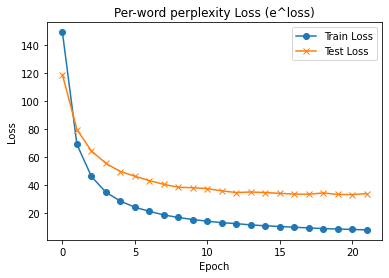

In [42]:
# Plotting metrics to see how model as learned and loss decreased
import numpy as np
import matplotlib.pyplot as plt

plt.plot(range(N_EPOCHS), np.exp(trainLoss), marker='o')
plt.plot(range(N_EPOCHS), np.exp(testLoss), marker = 'x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])
plt.title("Per-word perplexity Loss (e^loss)")
#plt.ylim([0,1.5])
plt.show()

In [43]:
import os, pickle
import spacy

nlp = spacy.load('en')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
def rephraseQuestion(ques, SRC, TRG, model, maxLength = 100):
  model.eval()

  # tokenize
  tokenized = [tok.text.lower() for tok in nlp.tokenizer(ques)] 
  #print('tokenized: ', tokenized)

  # add <sos> and add <eos>
  tokenized = ['<sos>'] + tokenized + ['<eos>']
  #print('tokenized: ', tokenized)

  # convert to integer sequence using predefined tokenizer dictionary
  indexed = [SRC.vocab.stoi[t] for t in tokenized]        
  #print('indexed: ', indexed)

  # compute no. of words        
  length = [len(indexed)]
  #print('length : ', length)

  # convert to tensor                                    
  tensor = torch.LongTensor(indexed).to(device)   
  #print('tensor shape: ', tensor.shape)

  # reshape in form of batch, no. of words           
  tensor = tensor.unsqueeze(1) 
  #print('tensor shape: ', tensor.shape)


  with torch.no_grad():
    hidden, cell = model.encoder(tensor)

  #first input to the decoder is the <sos> tokens
  trg_indexes = [TRG.vocab.stoi[TRG.init_token]]

  for t in range(1, maxLength):
      
      trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
      #insert input token embedding, previous hidden and previous cell states
      #receive output tensor (predictions) and new hidden and cell states
      with torch.no_grad():
        output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
      
      #place predictions in a tensor holding predictions for each token
      #outputs[t] = output
      
      #decide if we are going to use teacher forcing or not
      #teacher_force = random.random() < teacher_forcing_ratio
      
      #get the highest predicted token from our predictions
      pred_token = output.argmax(1).item()
      #print(pred_token)


      trg_indexes.append(pred_token)

      if pred_token == TRG.vocab.stoi[TRG.eos_token]:
              break
      
  trg_tokens = [TRG.vocab.itos[i] for i in trg_indexes]
  words = trg_tokens[1:(len(trg_tokens)-1)]

  pred = ' '.join(words) 

  return pred

In [45]:
for j in range(10):
  i = random.randint(100,10000)
  print('*'*50)
  print('Input Quest    : ', df.question1[i])
  pred = rephraseQuestion(df.question1[i], SRC, TRG, model)
  print('Predicted Quest: ', pred)
  print('Actual Quest 2 : ', df.question2[i])


**************************************************
Input Quest    :  What is it like when the wife is older than the husband?
Predicted Quest:  what is it like to be a elder elder elder ?
Actual Quest 2 :  How does it feel for a wife to be elder than the husband?
**************************************************
Input Quest    :  Where can I get very friendly property transactions services in Sydney?
Predicted Quest:  where can i get best support property transactions in sydney ?
Actual Quest 2 :  Where can I get best property transaction support in Sydney?
**************************************************
Input Quest    :  What do you want from life?
Predicted Quest:  what do you want to do in your life ?
Actual Quest 2 :  What you want to do in your life?
**************************************************
Input Quest    :  What are some interesting facts about medicine?
Predicted Quest:  what are some interesting facts about <unk> ?
Actual Quest 2 :  What are some insane facts abou